# Modelling and Evaluation

## import dependencies

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
# import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score
# from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
# from PIL import Image

import matplotlib.pyplot as plt
import os


2024-05-08 14:32:26.390356: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 14:32:27.072761: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## set up directories

In [2]:
os.chdir(os.path.expanduser('~'))
os.chdir('Desktop/skin')

train_dir = 'inputs/work/train'
test_dir = 'inputs/work/test'
val_dir = 'inputs/work/validate'

## Data Preprocessing

In [3]:
image_size = (224, 224)
batch_size = 32
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)

# datagen = ImageDataGenerator(zoom_range = 0.1, rotation_range = 30, horizontal_flip = True, vertical_flip = True)

# datagen = ImageDataGenerator(
#     rotation_range=20, 
#     width_shift_range=0.10, 
#     height_shift_range=0.10, 
#     shear_range=0.1, 
#     zoom_range=0.1, 
#     horizontal_flip=True, 
#     vertical_flip=True, 
#     fill_mode='nearest',
#     rescale=1./255
# )

train_batches = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=classes
)

test_batches = datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=classes
)

valid_batches = datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=classes
)

Found 1807 images belonging to 7 classes.
Found 516 images belonging to 7 classes.
Found 261 images belonging to 7 classes.


## Build CNN and Train
* This step can be skipped if a model has been trained previously.

In [4]:
model = Sequential([
    Input(shape=(224,224,3)),
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=7, activation='softmax'),
])

model.compile(optimizer= Adam(learning_rate = 0.001), 
              loss= 'categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

2024-05-08 14:32:28.026419: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 14:32:28.062861: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │     1,404,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,424,455 (5.43 MB)

 Trainable params: 1,424,391 (5.43 MB)

 Non-trainable params: 64 (256.00 B)

Load previous model if it exists

In [5]:
if os.path.exists('outputs/model.keras'):
    model = load_model('outputs/model.keras')
    print('---> Previous Model loaded')
else: 
    print('---> Training new model')

---> Training new model


Training step, this is time consuming. The trained model is saved, so predictions can be tested without retraining the model and training can be resumed if desired. 

In [6]:
model.fit(
    x=train_batches, 
    validation_data=valid_batches,
    # callbacks=[EarlyStopping(monitor='val_loss', patience=3)],
    epochs=5, 
    verbose=1)
model.save('outputs/model.keras')

Epoch 1/5


/home/pxp/anaconda3/envs/ten3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 58s 992ms/step - accuracy: 0.2797 - loss: 25.2476 - val_accuracy: 0.4176 - val_loss: 2.4813
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 57s 986ms/step - accuracy: 0.5713 - loss: 1.6690 - val_accuracy: 0.3563 - val_loss: 2.8333
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 56s 969ms/step - accuracy: 0.7002 - loss: 0.9054 - val_accuracy: 0.5211 - val_loss: 1.7497
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 56s 964ms/step - accuracy: 0.9057 - loss: 0.3175 - val_accuracy: 0.4981 - val_loss: 2.0000
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 56s 965ms/step - accuracy: 0.9565 - loss: 0.1944 - val_accuracy: 0.5019 - val_loss: 1.9047


### Model Evaluation

This step requires training the model, or there will be no history data.  

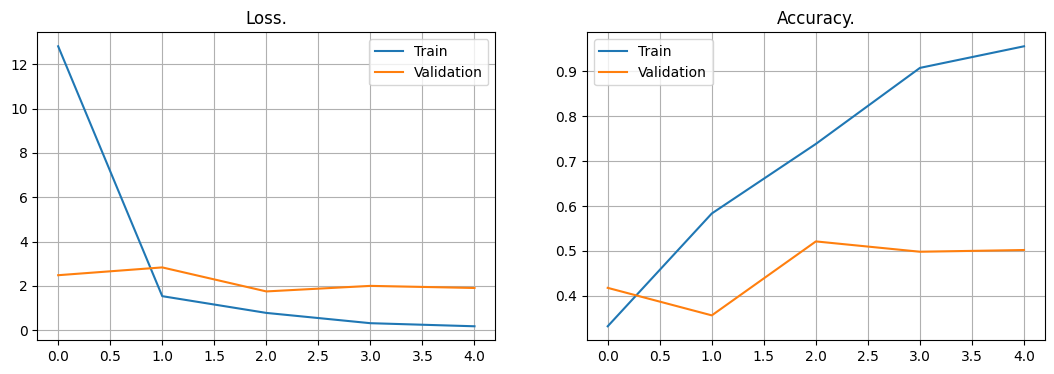

In [7]:
metrics = model.history.history

train_loss = metrics["loss"]
train_accuracy = metrics["accuracy"]

val_loss = metrics["val_loss"]
val_accuracy = metrics["val_accuracy"]

plt.figure(figsize = (13,4))
plt.subplot(1,2,1)
plt.title("Loss.")
plt.plot(train_loss, label = "Train");
plt.plot(val_loss, label = "Validation");
plt.grid(True)
plt.legend(loc = "best");

plt.subplot(1,2,2)
plt.title("Accuracy.")
plt.plot(train_accuracy, label = "Train");
plt.plot(val_accuracy, label = "Validation");
plt.grid(True)
plt.legend(loc = "best");

## Model Prediction

In [8]:
model = load_model('outputs/model.keras')

In [9]:
batch = test_batches
predictions = model.predict(x=batch, verbose=0)
true_labels = batch.classes
predicted_labels = np.argmax(predictions, axis=1)
class_names = {v: k for k, v in batch.class_indices.items()}
report = classification_report(true_labels, predicted_labels, target_names=class_names.values())
print(report)

              precision    recall  f1-score   support

       akiec       0.18      0.31      0.23        65
         bcc       0.26      0.19      0.22       100
         bkl       0.20      0.19      0.20       100
          df       0.00      0.00      0.00        23
         mel       0.17      0.24      0.20       100
          nv       0.16      0.13      0.14       100
        vasc       0.07      0.04      0.05        28

    accuracy                           0.19       516
   macro avg       0.15      0.16      0.15       516
weighted avg       0.18      0.19      0.18       516



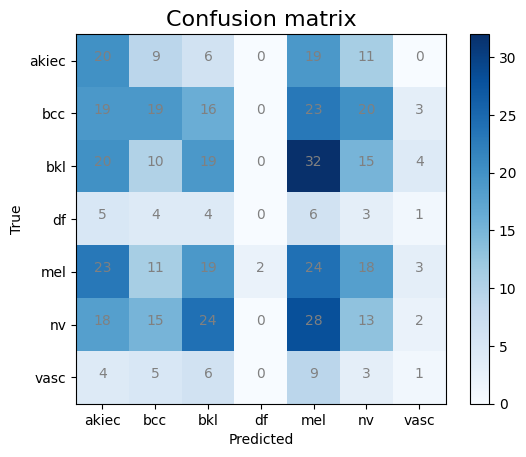

In [10]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
# classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix', fontsize=16)
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.ylabel('True')
plt.xlabel('Predicted')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="gray")